In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment1/'
# FOLDERNAME = None
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [11]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5, 1e-6]
regularization_strengths = [1e3, 5e4, 5e5, 1e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        temp_svm = LinearSVM()
        loss_hist = temp_svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=20000, verbose=True)
        val_pred = temp_svm.predict(X_val_feats)
        val_acc = np.mean(y_val == val_pred)
        train_acc = np.mean(y_train == temp_svm.predict(X_train_feats))
        if val_acc > best_val:
            best_val = val_acc
            best_svm = temp_svm
        results[(lr,rs)] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 20000: loss 10.567442
iteration 100 / 20000: loss 10.582120
iteration 200 / 20000: loss 10.761645
iteration 300 / 20000: loss 11.055066
iteration 400 / 20000: loss 11.539584
iteration 500 / 20000: loss 12.112213
iteration 600 / 20000: loss 12.874053
iteration 700 / 20000: loss 13.763647
iteration 800 / 20000: loss 14.789600
iteration 900 / 20000: loss 15.950481
iteration 1000 / 20000: loss 17.277294
iteration 1100 / 20000: loss 18.815522
iteration 1200 / 20000: loss 20.305589
iteration 1300 / 20000: loss 22.064875
iteration 1400 / 20000: loss 24.031040
iteration 1500 / 20000: loss 25.860866
iteration 1600 / 20000: loss 28.133300
iteration 1700 / 20000: loss 30.409381
iteration 1800 / 20000: loss 32.639127
iteration 1900 / 20000: loss 35.444763
iteration 2000 / 20000: loss 37.995363
iteration 2100 / 20000: loss 40.844455
iteration 2200 / 20000: loss 43.560440
iteration 2300 / 20000: loss 46.889096
iteration 2400 / 20000: loss 49.970336
iteration 2500 / 20000: loss 53.64296

iteration 2200 / 20000: loss 1812.706965
iteration 2300 / 20000: loss 1970.564650
iteration 2400 / 20000: loss 2135.676170
iteration 2500 / 20000: loss 2306.546625
iteration 2600 / 20000: loss 2484.250366
iteration 2700 / 20000: loss 2665.857600
iteration 2800 / 20000: loss 2852.388762
iteration 2900 / 20000: loss 3045.189391
iteration 3000 / 20000: loss 3241.420700
iteration 3100 / 20000: loss 3444.660617
iteration 3200 / 20000: loss 3650.396744
iteration 3300 / 20000: loss 3860.409539
iteration 3400 / 20000: loss 4072.485157
iteration 3500 / 20000: loss 4289.432653
iteration 3600 / 20000: loss 4507.080201
iteration 3700 / 20000: loss 4726.941024
iteration 3800 / 20000: loss 4950.416029
iteration 3900 / 20000: loss 5171.479376
iteration 4000 / 20000: loss 5397.277281
iteration 4100 / 20000: loss 5623.809652
iteration 4200 / 20000: loss 5851.700596
iteration 4300 / 20000: loss 6079.158002
iteration 4400 / 20000: loss 6306.902469
iteration 4500 / 20000: loss 6534.948416
iteration 4600 /

iteration 2500 / 20000: loss 22404.074033
iteration 2600 / 20000: loss 24141.179585
iteration 2700 / 20000: loss 25963.911296
iteration 2800 / 20000: loss 27835.947602
iteration 2900 / 20000: loss 29740.263885
iteration 3000 / 20000: loss 31709.579076
iteration 3100 / 20000: loss 33741.451880
iteration 3200 / 20000: loss 35794.443903
iteration 3300 / 20000: loss 37907.696098
iteration 3400 / 20000: loss 40016.555010
iteration 3500 / 20000: loss 42167.526973
iteration 3600 / 20000: loss 44340.238808
iteration 3700 / 20000: loss 46516.938008
iteration 3800 / 20000: loss 48724.694271
iteration 3900 / 20000: loss 50967.238273
iteration 4000 / 20000: loss 53197.614528
iteration 4100 / 20000: loss 55467.377251
iteration 4200 / 20000: loss 57736.072764
iteration 4300 / 20000: loss 60015.518936
iteration 4400 / 20000: loss 62315.096345
iteration 4500 / 20000: loss 64619.187456
iteration 4600 / 20000: loss 66922.054290
iteration 4700 / 20000: loss 69242.407854
iteration 4800 / 20000: loss 71577

iteration 2800 / 20000: loss 56566.159047
iteration 2900 / 20000: loss 60417.586417
iteration 3000 / 20000: loss 64379.833085
iteration 3100 / 20000: loss 68440.528192
iteration 3200 / 20000: loss 72576.490324
iteration 3300 / 20000: loss 76742.224490
iteration 3400 / 20000: loss 80995.479182
iteration 3500 / 20000: loss 85282.836856
iteration 3600 / 20000: loss 89613.988785
iteration 3700 / 20000: loss 93990.451111
iteration 3800 / 20000: loss 98444.369392
iteration 3900 / 20000: loss 102915.025751
iteration 4000 / 20000: loss 107461.118276
iteration 4100 / 20000: loss 111998.809864
iteration 4200 / 20000: loss 116542.520222
iteration 4300 / 20000: loss 121016.740023
iteration 4400 / 20000: loss 125570.742152
iteration 4500 / 20000: loss 130155.175454
iteration 4600 / 20000: loss 134774.767445
iteration 4700 / 20000: loss 139379.067247
iteration 4800 / 20000: loss 143961.673631
iteration 4900 / 20000: loss 148579.019275
iteration 5000 / 20000: loss 153204.989073
iteration 5100 / 20000

iteration 3100 / 20000: loss 11.015618
iteration 3200 / 20000: loss 11.057048
iteration 3300 / 20000: loss 11.089366
iteration 3400 / 20000: loss 11.115791
iteration 3500 / 20000: loss 11.159487
iteration 3600 / 20000: loss 11.205622
iteration 3700 / 20000: loss 11.216745
iteration 3800 / 20000: loss 11.292131
iteration 3900 / 20000: loss 11.376087
iteration 4000 / 20000: loss 11.403869
iteration 4100 / 20000: loss 11.434986
iteration 4200 / 20000: loss 11.499944
iteration 4300 / 20000: loss 11.539732
iteration 4400 / 20000: loss 11.615594
iteration 4500 / 20000: loss 11.639313
iteration 4600 / 20000: loss 11.690562
iteration 4700 / 20000: loss 11.736244
iteration 4800 / 20000: loss 11.812104
iteration 4900 / 20000: loss 11.841002
iteration 5000 / 20000: loss 11.943550
iteration 5100 / 20000: loss 12.026428
iteration 5200 / 20000: loss 12.107680
iteration 5300 / 20000: loss 12.195777
iteration 5400 / 20000: loss 12.212872
iteration 5500 / 20000: loss 12.242070
iteration 5600 / 20000: l

iteration 4800 / 20000: loss 168.498412
iteration 4900 / 20000: loss 171.883355
iteration 5000 / 20000: loss 175.457253
iteration 5100 / 20000: loss 178.972007
iteration 5200 / 20000: loss 182.501003
iteration 5300 / 20000: loss 186.284180
iteration 5400 / 20000: loss 190.103325
iteration 5500 / 20000: loss 193.883378
iteration 5600 / 20000: loss 197.792822
iteration 5700 / 20000: loss 201.774303
iteration 5800 / 20000: loss 205.783372
iteration 5900 / 20000: loss 209.957544
iteration 6000 / 20000: loss 214.157291
iteration 6100 / 20000: loss 218.449927
iteration 6200 / 20000: loss 222.714314
iteration 6300 / 20000: loss 227.251393
iteration 6400 / 20000: loss 231.649247
iteration 6500 / 20000: loss 236.198459
iteration 6600 / 20000: loss 240.810717
iteration 6700 / 20000: loss 245.541312
iteration 6800 / 20000: loss 250.322859
iteration 6900 / 20000: loss 255.172706
iteration 7000 / 20000: loss 259.990397
iteration 7100 / 20000: loss 264.880180
iteration 7200 / 20000: loss 269.981774


iteration 6500 / 20000: loss 2418.329598
iteration 6600 / 20000: loss 2466.217213
iteration 6700 / 20000: loss 2514.261485
iteration 6800 / 20000: loss 2563.373541
iteration 6900 / 20000: loss 2612.917702
iteration 7000 / 20000: loss 2663.562171
iteration 7100 / 20000: loss 2714.409124
iteration 7200 / 20000: loss 2766.444146
iteration 7300 / 20000: loss 2819.012084
iteration 7400 / 20000: loss 2872.442265
iteration 7500 / 20000: loss 2926.669614
iteration 7600 / 20000: loss 2981.723511
iteration 7700 / 20000: loss 3037.437706
iteration 7800 / 20000: loss 3093.879969
iteration 7900 / 20000: loss 3150.908185
iteration 8000 / 20000: loss 3208.769487
iteration 8100 / 20000: loss 3267.055961
iteration 8200 / 20000: loss 3326.080462
iteration 8300 / 20000: loss 3385.770163
iteration 8400 / 20000: loss 3446.783727
iteration 8500 / 20000: loss 3508.405669
iteration 8600 / 20000: loss 3570.046864
iteration 8700 / 20000: loss 3632.502795
iteration 8800 / 20000: loss 3695.724228
iteration 8900 /

iteration 6300 / 20000: loss 4551.387688
iteration 6400 / 20000: loss 4643.691582
iteration 6500 / 20000: loss 4736.990190
iteration 6600 / 20000: loss 4832.157168
iteration 6700 / 20000: loss 4928.611129
iteration 6800 / 20000: loss 5026.203137
iteration 6900 / 20000: loss 5124.442982
iteration 7000 / 20000: loss 5224.680817
iteration 7100 / 20000: loss 5326.499523
iteration 7200 / 20000: loss 5430.280525
iteration 7300 / 20000: loss 5533.924478
iteration 7400 / 20000: loss 5639.805434
iteration 7500 / 20000: loss 5746.688333
iteration 7600 / 20000: loss 5855.403522
iteration 7700 / 20000: loss 5965.511646
iteration 7800 / 20000: loss 6075.707220
iteration 7900 / 20000: loss 6188.861995
iteration 8000 / 20000: loss 6302.974529
iteration 8100 / 20000: loss 6418.046526
iteration 8200 / 20000: loss 6535.848346
iteration 8300 / 20000: loss 6654.283809
iteration 8400 / 20000: loss 6774.406132
iteration 8500 / 20000: loss 6895.130641
iteration 8600 / 20000: loss 7016.937641
iteration 8700 /

In [12]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.469


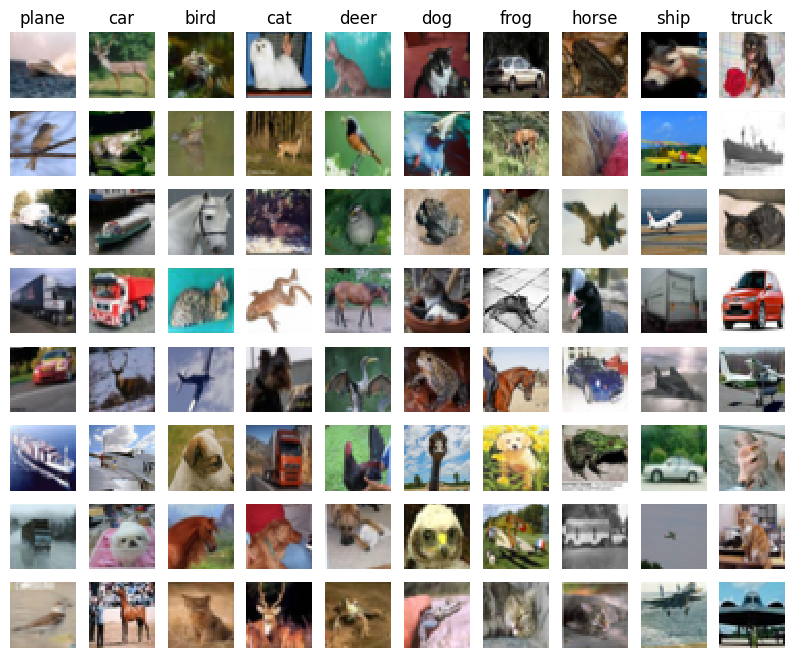

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

In [52]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
# hidden_dim = 500
num_classes = 10
best_val_acc = -1

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
#best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hidden_sizes = [1000]
learning_rates = [5e-2]
regs = [0.93]

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for reg in regs:
            print(f'===================hidden: {hidden_size}, lr: {lr}, reg: {reg}=====================')
            model = TwoLayerNet(input_dim, hidden_size, num_classes)
            solver = Solver(
                model=model,
                data=data,
                update_rule='sgd',
                optim_config={'learning_rate': lr},
                batch_size=512,
                num_epochs=75,
            )
            solver.train()
            if solver.best_val_acc > best_val_acc:
                best_val_acc = solver.best_val_acc
                best_net = model
                best_solver = solver
                
print(f'Best val accuracy: {best_val_acc}')
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


===================hidden: 1000, lr: 0.05, reg: 0.93=====================
(Iteration 1 / 7125) loss: 2.302605
(Epoch 0 / 75) train acc: 0.098000; val_acc: 0.079000
(Iteration 11 / 7125) loss: 2.302648
(Iteration 21 / 7125) loss: 2.301924
(Iteration 31 / 7125) loss: 2.302103
(Iteration 41 / 7125) loss: 2.301723
(Iteration 51 / 7125) loss: 2.301523
(Iteration 61 / 7125) loss: 2.300993
(Iteration 71 / 7125) loss: 2.300249
(Iteration 81 / 7125) loss: 2.299419
(Iteration 91 / 7125) loss: 2.299047
(Epoch 1 / 75) train acc: 0.207000; val_acc: 0.207000
(Iteration 101 / 7125) loss: 2.297098
(Iteration 111 / 7125) loss: 2.295175
(Iteration 121 / 7125) loss: 2.291555
(Iteration 131 / 7125) loss: 2.288757
(Iteration 141 / 7125) loss: 2.283332
(Iteration 151 / 7125) loss: 2.275360
(Iteration 161 / 7125) loss: 2.263074
(Iteration 171 / 7125) loss: 2.251338
(Iteration 181 / 7125) loss: 2.241101
(Epoch 2 / 75) train acc: 0.286000; val_acc: 0.284000
(Iteration 191 / 7125) loss: 2.221199
(Iteration 201 

(Iteration 1841 / 7125) loss: 1.293113
(Iteration 1851 / 7125) loss: 1.352167
(Iteration 1861 / 7125) loss: 1.301326
(Iteration 1871 / 7125) loss: 1.322936
(Iteration 1881 / 7125) loss: 1.322085
(Iteration 1891 / 7125) loss: 1.295473
(Epoch 20 / 75) train acc: 0.528000; val_acc: 0.525000
(Iteration 1901 / 7125) loss: 1.250903
(Iteration 1911 / 7125) loss: 1.346077
(Iteration 1921 / 7125) loss: 1.264165
(Iteration 1931 / 7125) loss: 1.324841
(Iteration 1941 / 7125) loss: 1.322570
(Iteration 1951 / 7125) loss: 1.281680
(Iteration 1961 / 7125) loss: 1.379344
(Iteration 1971 / 7125) loss: 1.276815
(Iteration 1981 / 7125) loss: 1.271088
(Iteration 1991 / 7125) loss: 1.306799
(Epoch 21 / 75) train acc: 0.534000; val_acc: 0.526000
(Iteration 2001 / 7125) loss: 1.141523
(Iteration 2011 / 7125) loss: 1.272818
(Iteration 2021 / 7125) loss: 1.319785
(Iteration 2031 / 7125) loss: 1.271741
(Iteration 2041 / 7125) loss: 1.279276
(Iteration 2051 / 7125) loss: 1.304786
(Iteration 2061 / 7125) loss: 1.

(Iteration 3701 / 7125) loss: 1.220819
(Epoch 39 / 75) train acc: 0.588000; val_acc: 0.563000
(Iteration 3711 / 7125) loss: 1.234248
(Iteration 3721 / 7125) loss: 1.150082
(Iteration 3731 / 7125) loss: 1.087266
(Iteration 3741 / 7125) loss: 1.152032
(Iteration 3751 / 7125) loss: 1.200182
(Iteration 3761 / 7125) loss: 1.112212
(Iteration 3771 / 7125) loss: 1.131854
(Iteration 3781 / 7125) loss: 1.184673
(Iteration 3791 / 7125) loss: 1.168134
(Epoch 40 / 75) train acc: 0.584000; val_acc: 0.568000
(Iteration 3801 / 7125) loss: 1.119600
(Iteration 3811 / 7125) loss: 1.193239
(Iteration 3821 / 7125) loss: 1.131134
(Iteration 3831 / 7125) loss: 1.109011
(Iteration 3841 / 7125) loss: 1.090209
(Iteration 3851 / 7125) loss: 1.073619
(Iteration 3861 / 7125) loss: 1.070779
(Iteration 3871 / 7125) loss: 1.204145
(Iteration 3881 / 7125) loss: 1.189870
(Iteration 3891 / 7125) loss: 1.145175
(Epoch 41 / 75) train acc: 0.597000; val_acc: 0.566000
(Iteration 3901 / 7125) loss: 1.187239
(Iteration 3911 

(Iteration 5531 / 7125) loss: 0.983301
(Iteration 5541 / 7125) loss: 1.088511
(Iteration 5551 / 7125) loss: 1.004558
(Iteration 5561 / 7125) loss: 1.132904
(Iteration 5571 / 7125) loss: 0.992986
(Iteration 5581 / 7125) loss: 0.982492
(Iteration 5591 / 7125) loss: 0.977500
(Iteration 5601 / 7125) loss: 1.067591
(Epoch 59 / 75) train acc: 0.638000; val_acc: 0.602000
(Iteration 5611 / 7125) loss: 1.049874
(Iteration 5621 / 7125) loss: 1.031095
(Iteration 5631 / 7125) loss: 0.977773
(Iteration 5641 / 7125) loss: 1.020565
(Iteration 5651 / 7125) loss: 0.986771
(Iteration 5661 / 7125) loss: 0.986273
(Iteration 5671 / 7125) loss: 1.011613
(Iteration 5681 / 7125) loss: 0.980505
(Iteration 5691 / 7125) loss: 0.985212
(Epoch 60 / 75) train acc: 0.627000; val_acc: 0.600000
(Iteration 5701 / 7125) loss: 1.033561
(Iteration 5711 / 7125) loss: 0.937811
(Iteration 5721 / 7125) loss: 1.019152
(Iteration 5731 / 7125) loss: 1.067086
(Iteration 5741 / 7125) loss: 1.059996
(Iteration 5751 / 7125) loss: 0.

In [53]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.591


155
